In [1]:
from matplotlib import pyplot as plt
import pymatching
import numpy as np
from copy import deepcopy
from circuit_generators import *
from sampling_functions import *
from bitpack import pack_bits, unpack_bits
from circuit_partition import *
from utilities_tf import *


# Number of worker nodes
n_worker_nodes = 8

# Surface code specifications
d = 4
r = 2
kernel_size = 3
p = 0.01
use_rotated_z = True

# Bit types
binary_t = np.int8 # Could use even less if numpy allowed
packed_t = np.int8 # Packed bit type
if d<=8:
  pass
elif d>8 and d<=16:
  packed_t = np.int16
elif d>16 and d<=32:
  packed_t = np.int32
elif d>32 and d<=64:
  packed_t = np.int64
elif d>64 and d<=128:
  packed_t = np.int128
elif d>128 and d<=256:
  packed_t = np.int256
else:
  raise RuntimeError("d is too large.")
time_t = np.int8

# Measurement index type
idx_t = np.int8
n_all_measurements = r*(d**2-1) + d**2
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int16
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int32
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int64
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int128
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int256
if n_all_measurements > np.iinfo(idx_t).max:
  raise RuntimeError("idx_t is too small.")

# Call signature for circuit_partition::group_det_bits_kxk
call_group_det_bits_kxk = lambda det_bits_dxd, data_bits_dxd=None, d=d, r=r, k=kernel_size, use_rotated_z=use_rotated_z, binary_t=binary_t, idx_t=idx_t: group_det_bits_kxk(det_bits_dxd, d, r, k, use_rotated_z, data_bits_dxd, binary_t, idx_t)

# Call signature for bitpack::pack_bits
call_pack_bits = lambda bits, packed_t=packed_t: pack_bits(bits, bits.shape[0], packed_t=packed_t)

In [2]:
n_test = 10000000
n_train = 10000000
n_samples = n_test + n_train
decoders = ['pymatching']
test_circuit = get_builtin_circuit(
  "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
  distance=d,
  rounds=r,
  before_round_data_depolarization = p,
  after_reset_flip_probability = p,
  after_clifford_depolarization = p,
  before_measure_flip_probability = p
)

kernel_circuit = stim.Circuit(
  f"""
QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19
X_ERROR(0.01) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.01) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE1(0.01) 13 25
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE1(0.01) 5 13 17 19 25
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 13
#DEPOLARIZE1(0.01)
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.01) 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE1(0.01) 12 15 19
TICK
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
X_ERROR(0.01) 2 9 11 13 14 16 18 25
MR 2 9 11 13 14 16 18 25
X_ERROR(0.01) 2 9 11 13 14 16 18 25
DETECTOR(0, 4, 0) rec[-4]
DETECTOR(2, 2, 0) rec[-7]
DETECTOR(4, 4, 0) rec[-2]
DETECTOR(6, 2, 0) rec[-5]
REPEAT {r-1} {{
  TICK
  DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
  H 2 11 16 25
  DEPOLARIZE1(0.01) 2 11 16 25
  TICK
  CX 2 3 16 17 11 12 15 14 10 9 19 18
  DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
  DEPOLARIZE1(0.01) 13 25
  TICK
  CX 2 1 16 15 11 10 8 14 3 9 12 18
  DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
  DEPOLARIZE1(0.01) 5 13 17 19 25
  TICK
  CX 16 10 11 5 25 19 8 9 17 18 12 13
  DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 13
  #DEPOLARIZE1(0.01)
  TICK
  CX 16 8 11 3 25 17 1 9 10 18 5 13
  DEPOLARIZE2(0.01) 16 8 11 3 25 17 1 9 10 18 5 13
  DEPOLARIZE1(0.01) 12 15 19
  TICK
  H 2 11 16 25
  DEPOLARIZE1(0.01) 2 11 16 25
  TICK
  X_ERROR(0.01) 2 9 11 13 14 16 18 25
  MR 2 9 11 13 14 16 18 25
  X_ERROR(0.01) 2 9 11 13 14 16 18 25
  SHIFT_COORDS(0, 0, 1)
  DETECTOR(2, 0, 0) rec[-8] rec[-16]
  DETECTOR(2, 2, 0) rec[-7] rec[-15]
  DETECTOR(4, 2, 0) rec[-6] rec[-14]
  DETECTOR(6, 2, 0) rec[-5] rec[-13]
  DETECTOR(0, 4, 0) rec[-4] rec[-12]
  DETECTOR(2, 4, 0) rec[-3] rec[-11]
  DETECTOR(4, 4, 0) rec[-2] rec[-10]
  DETECTOR(4, 6, 0) rec[-1] rec[-9]
}}
X_ERROR(0.01) 1 3 5 8 10 12 15 17 19
M 1 3 5 8 10 12 15 17 19
DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
  """
)

# Sampling for the dxd circuit
m_sampler = test_circuit.compile_sampler(seed=12345)
d_sampler = test_circuit.compile_detector_sampler(seed=12345)
converter = test_circuit.compile_m2d_converter()
detector_error_model = test_circuit.detector_error_model(decompose_errors=True)

measurements = m_sampler.sample(n_samples, bit_packed=False)
det_evts, flips = converter.convert(measurements=measurements, separate_observables=True, bit_packed=False)
measurements = measurements.astype(binary_t)
det_evts = det_evts.astype(binary_t)
flips = flips.astype(binary_t)

avg_flips = np.sum(flips.reshape(-1,), dtype=np.float32)/flips.shape[0]
print(f"Average flip rate for the full circuit: {avg_flips}")

# Sampling for the kxk kernel
m_sampler_kernel = kernel_circuit.compile_sampler(seed=12345)
d_sampler_kernel = kernel_circuit.compile_detector_sampler(seed=12345)
converter_kernel = kernel_circuit.compile_m2d_converter()
detector_error_model_kernel = kernel_circuit.detector_error_model(decompose_errors=True)

measurements_kernel = m_sampler_kernel.sample(n_samples, bit_packed=False)
det_evts_kernel, flips_kernel = converter_kernel.convert(measurements=measurements_kernel, separate_observables=True, bit_packed=False)
measurements_kernel = measurements_kernel.astype(binary_t)
det_evts_kernel = det_evts_kernel.astype(binary_t)
flips_kernel = flips_kernel.astype(binary_t)

avg_flips_kernel = np.sum(flips_kernel.reshape(-1,), dtype=np.float32)/flips_kernel.shape[0]
print(f"Average flip rate for the kernel sample: {avg_flips_kernel}")

Average flip rate for the full circuit: 0.19171115
Average flip rate for the kernel sample: 0.15777895


QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(6, 0) 6
QUBIT_COORDS(7, 1) 7
QUBIT_COORDS(1, 3) 10
QUBIT_COORDS(2, 2) 11
QUBIT_COORDS(3, 3) 12
QUBIT_COORDS(4, 2) 13
QUBIT_COORDS(5, 3) 14
QUBIT_COORDS(6, 2) 15
QUBIT_COORDS(7, 3) 16
QUBIT_COORDS(0, 4) 18
QUBIT_COORDS(1, 5) 19
QUBIT_COORDS(2, 4) 20
QUBIT_COORDS(3, 5) 21
QUBIT_COORDS(4, 4) 22
QUBIT_COORDS(5, 5) 23
QUBIT_COORDS(6, 4) 24
QUBIT_COORDS(7, 5) 25
QUBIT_COORDS(8, 4) 26
QUBIT_COORDS(1, 7) 28
QUBIT_COORDS(2, 6) 29
QUBIT_COORDS(3, 7) 30
QUBIT_COORDS(4, 6) 31
QUBIT_COORDS(5, 7) 32
QUBIT_COORDS(6, 6) 33
QUBIT_COORDS(7, 7) 34
QUBIT_COORDS(2, 8) 38
QUBIT_COORDS(6, 8) 42
R 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
X_ERROR(0.01) 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
R 2 6 11 13 15 18 20 22 24 26 29 31 33 38 42
X_ERROR(0.01) 2 6 11 13 15 18 20 22 24 26 29 31 33 38 42
TICK
DEPOLARIZE1(0.01) 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
H 2 6 13 20 24 31 38 42
DEPOLARIZE1(0.01) 2 6 13 20

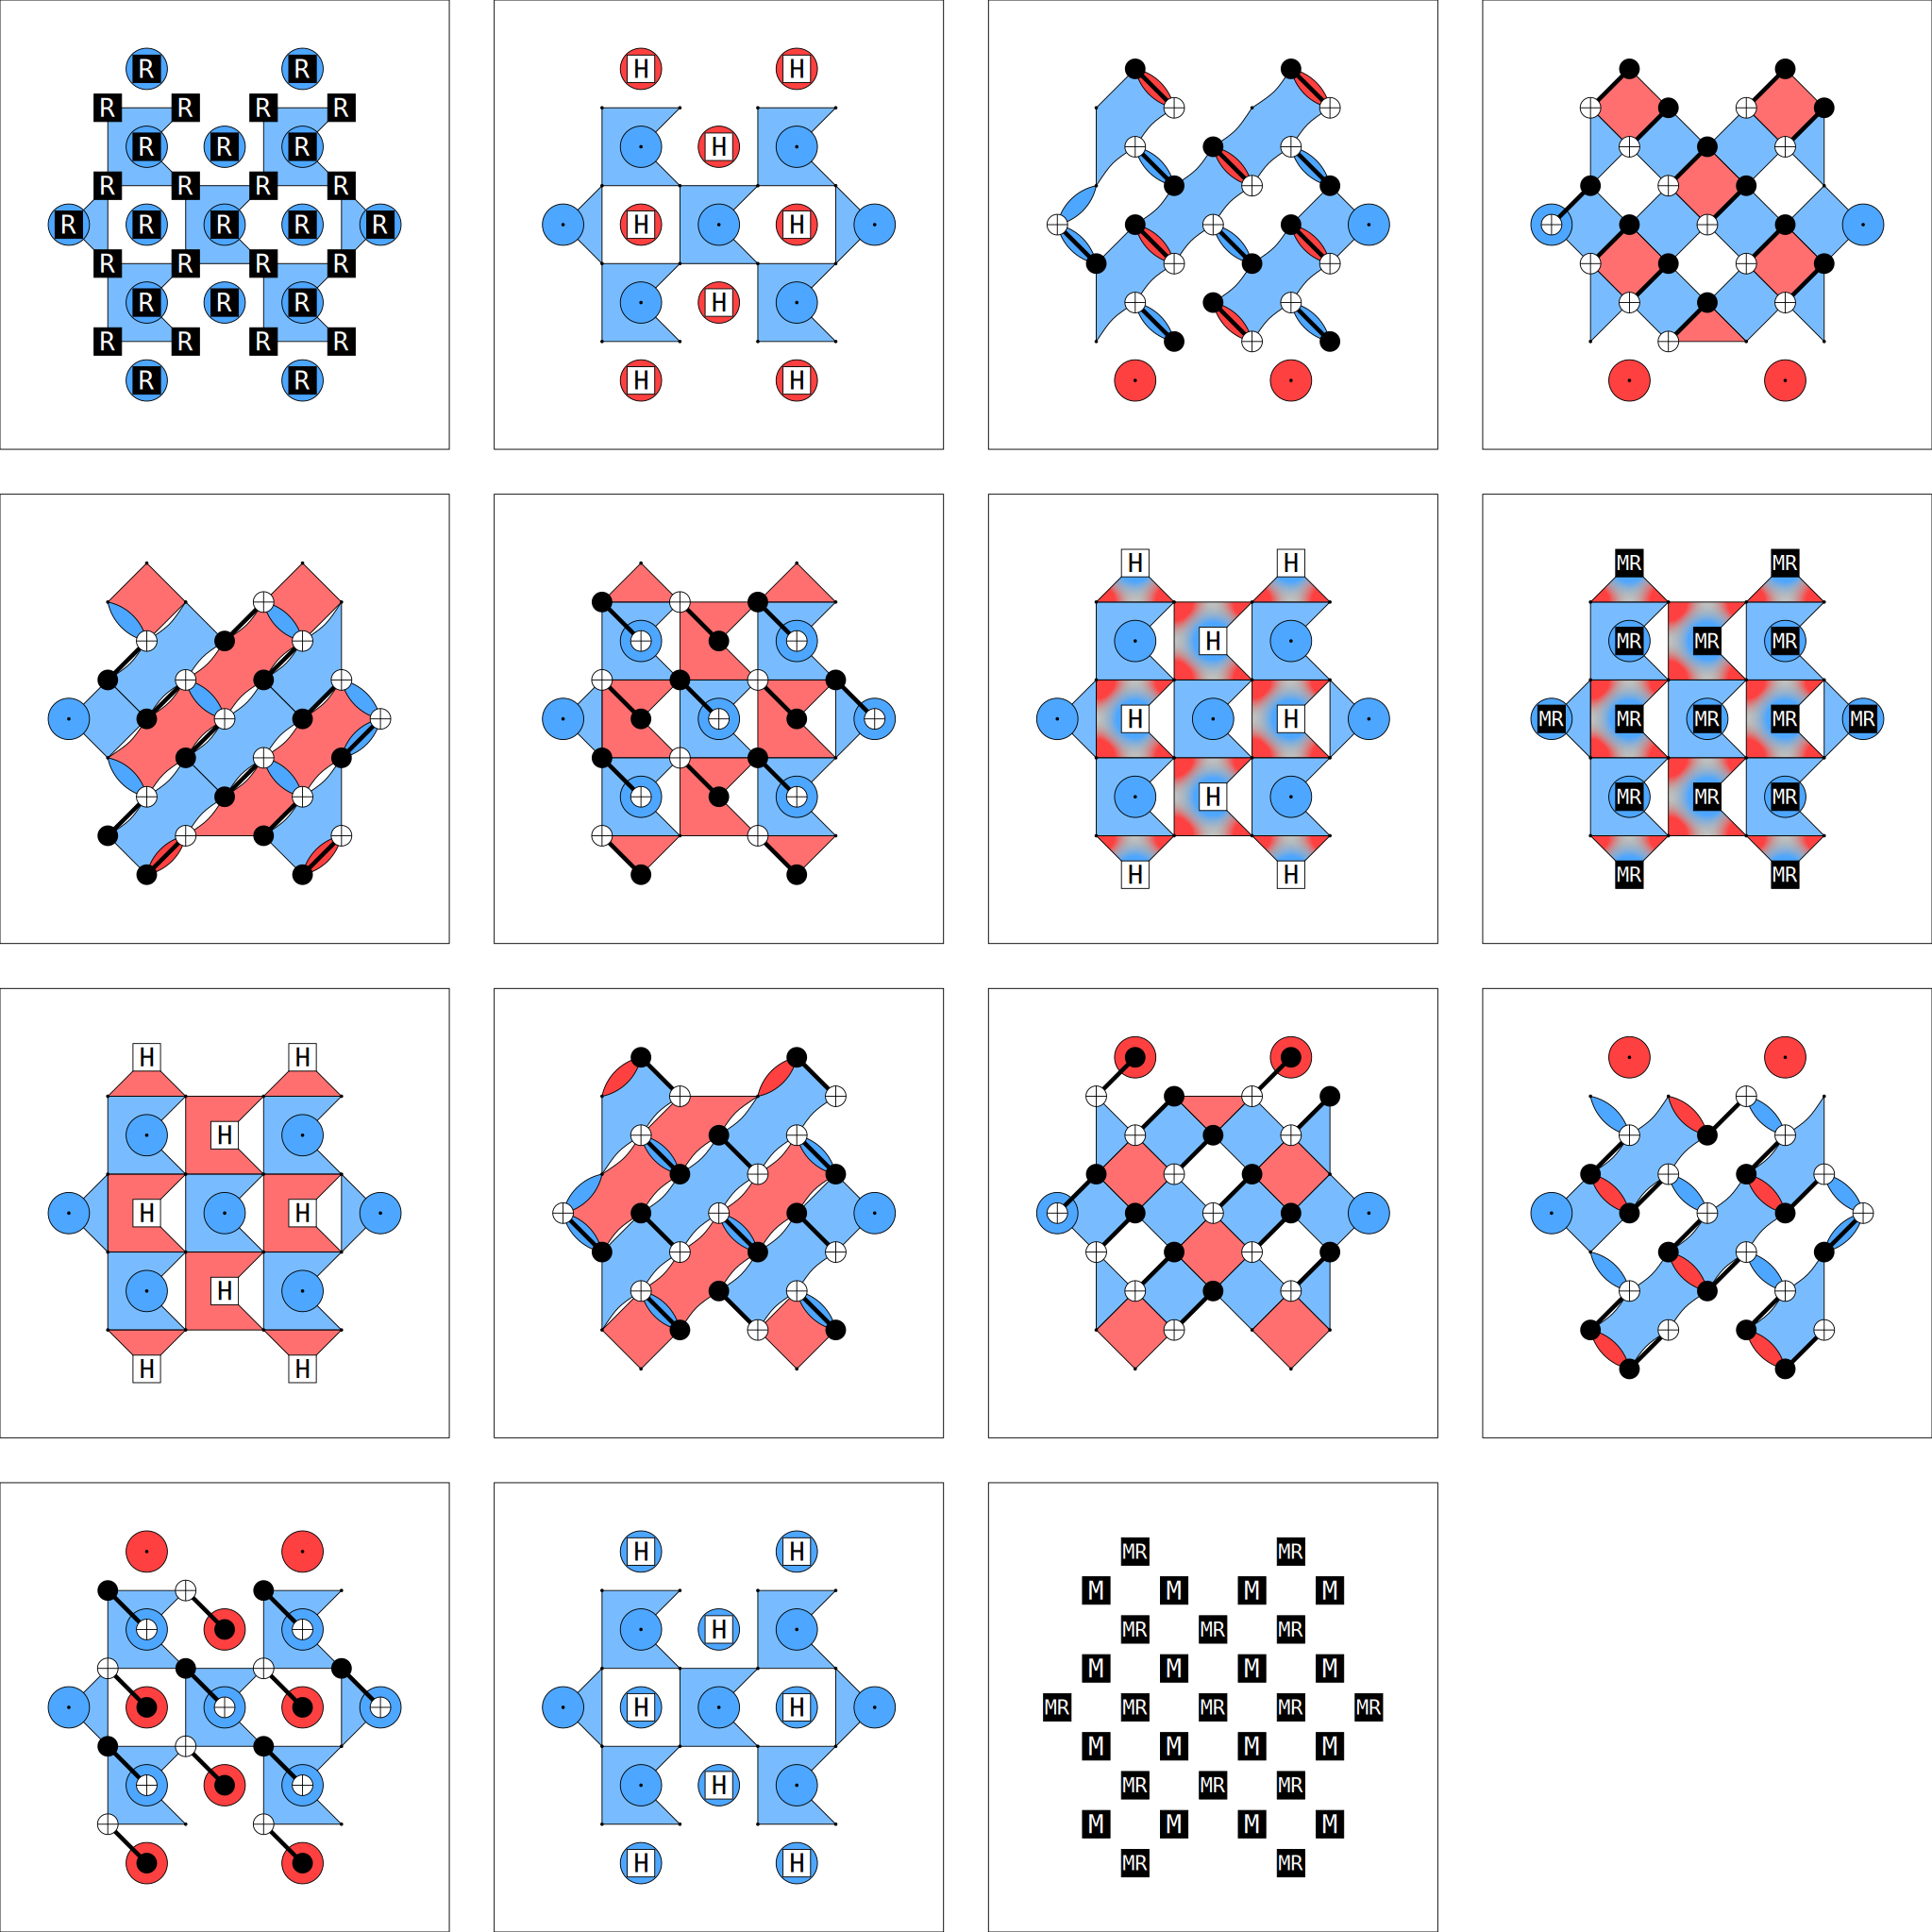

In [3]:
print(test_circuit)
test_circuit.without_noise().diagram('detslice-with-ops-svg')

QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
R 1 3 5 8 10 12 15 17 19
X_ERROR(0.01) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.01) 2 9 11 13 14 16 18 25
TICK
DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.01) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE1(0.01) 13 25
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE1(0.01) 5 13 17 19 25
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.01) 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLA

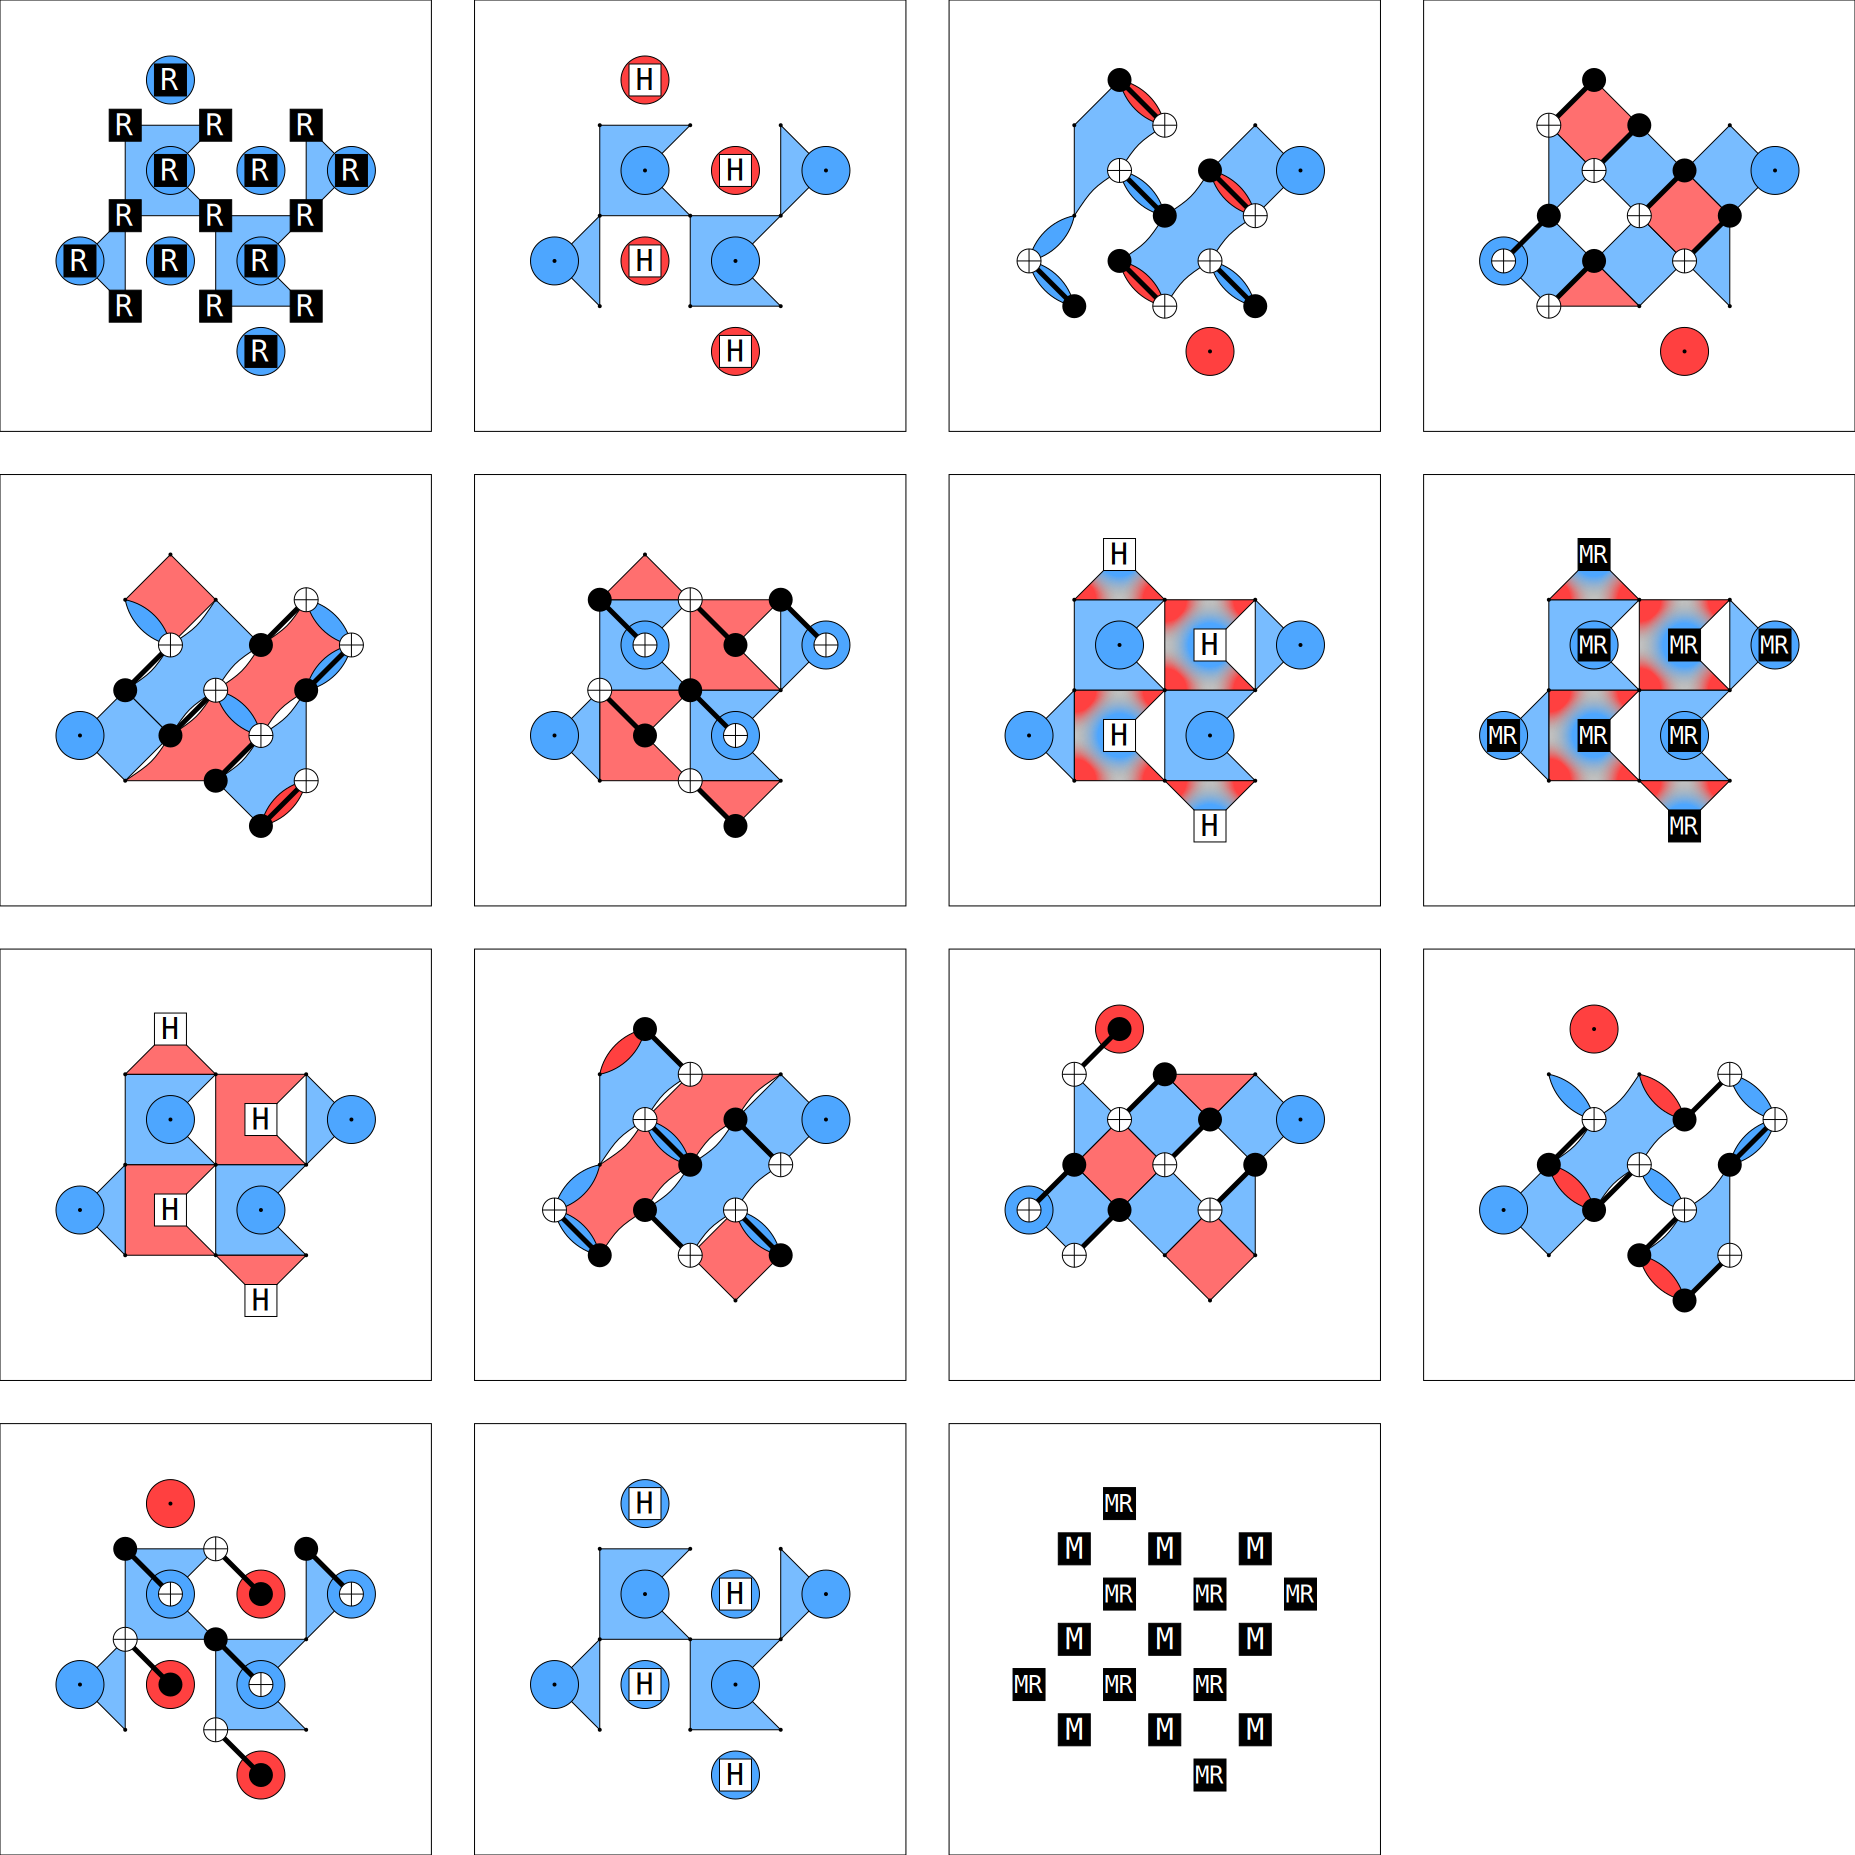

In [4]:
print(kernel_circuit)
kernel_circuit.without_noise().diagram('detslice-with-ops-svg')

In [5]:
def split_measurements(measurements, d):
  n_measurements = idx_t(measurements.shape[1])
  # Measurements on data qubits come last
  exclude_indices = np.array([-x-1 for x in range(d**2)], dtype=idx_t)
  exclude_indices = exclude_indices + n_measurements
  # Out of all measurements on data qubits, the logical qubit measurements are those on the boundary of the lattice.
  # All other equivalent X_L/Z_L operators can be found through the combination of ancilla measurements and the chosen data qubits giving us the logical qubit.
  exclude_indices_obsL = np.array([-x-1 for x in range(d*(d-1), d**2)], dtype=idx_t)
  exclude_indices_obsL = exclude_indices_obsL + n_measurements
  # From obs_bits, we want to exclude all measurements except those listed in exclude_indices_obsL
  exclude_indices_obs = np.arange(0, n_measurements, 1, dtype=idx_t)
  exclude_indices_obs = np.delete(exclude_indices_obs, exclude_indices_obsL)

  det_bits = measurements
  det_bits = np.delete(det_bits, exclude_indices, axis=1)
  obs_bits = measurements
  obs_bits = np.delete(obs_bits, exclude_indices_obs, axis=1)

  data_bits = measurements[:, exclude_indices]

  # Reverse the order of data_bits because exclude_indices starts from the last data qubit measurement, not the first
  data_bits = np.flip(data_bits, axis=1)

  return det_bits, obs_bits, data_bits


n_measurements = idx_t(measurements.shape[1])
det_bits, obs_bits, data_bits = split_measurements(measurements, d)
print(obs_bits)

# Do the same for the kernels
det_bits_kernel, obs_bits_kernel, _ = split_measurements(measurements_kernel, kernel_size)
print(obs_bits_kernel)

[[0 1 0 0]
 [0 1 1 0]
 [0 1 1 0]
 ...
 [1 1 0 0]
 [0 0 1 0]
 [1 0 0 1]]
[[1 1 1]
 [1 1 0]
 [0 1 1]
 ...
 [0 1 1]
 [0 0 1]
 [0 0 0]]


In [6]:
det_bits_kxk_all, data_bits_kxk_all, obs_bits_kxk_all, kernel_result_translation_map = call_group_det_bits_kxk(det_bits, data_bits_dxd=data_bits)
print(det_bits_kxk_all.shape)
print(data_bits_kxk_all.shape)
print(obs_bits_kxk_all.shape)
print(kernel_result_translation_map.shape)

print(flips[0])
print(det_bits[0])
print(data_bits[0])

kernel_types = get_unique_kernel_types(kernel_size, d)
n_kernels = det_bits_kxk_all.shape[0]
n_kernel_rows = int(np.sqrt(n_kernels))
for k in range(n_kernels):
  print(det_bits_kxk_all[k][0])
  print(data_bits_kxk_all[k][0])
  print(obs_bits_kxk_all[k][0])
  if k % n_kernel_rows == 0:
    print(kernel_result_translation_map[k//n_kernel_rows][0])

det_evts_kxk_all = []
flips_kxk_all = []
for k in range(n_kernels):
  measurements_kxk = np.concatenate((det_bits_kxk_all[k], data_bits_kxk_all[k]), axis=1).astype(np.bool_)
  det_evts_kxk, flips_kxk = converter_kernel.convert(measurements=measurements_kxk, separate_observables=True, bit_packed=False)
  det_evts_kxk_all.append(det_evts_kxk)
  flips_kxk_all.append(flips_kxk)
det_evts_kxk_all = np.array(det_evts_kxk_all, dtype=binary_t)
flips_kxk_all = np.array(flips_kxk_all, dtype=binary_t)
print(det_evts_kxk_all.shape)
print(flips_kxk_all.shape)

(4, 20000000, 16)
(4, 20000000, 9)
(4, 20000000, 3)
(2, 20000000, 2)
[1]
[1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1]
[0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0]
[1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1]
[0 1 0 1 0 0 1 0 0]
[0 1 0]
[0 0]
[1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1]
[0 0 1 1 0 0 1 0 0]
[1 0 0]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0]
[0 1 1 1 0 0 1 0 0]
[1 1 0]
[1 1]
[0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0]
[0 1 1 1 0 0 1 0 0]
[1 1 0]
(4, 20000000, 16)
(4, 20000000, 1)


Yay!

Evaluate the performance of PyMatching on the 3x3 kernels:

In [7]:
pymatcher_kxk = pymatching.Matching.from_detector_error_model(detector_error_model_kernel)
for kernel_type in kernel_types:
  predictions_kxk_pym = pymatcher_kxk.decode_batch(det_evts_kernel, bit_packed_predictions=False, bit_packed_shots=False).astype(packed_t)
  incorrect_matches_kxk = (predictions_kxk_pym != flips_kernel)
  incorrect_rate_kxk_pym = np.sum(incorrect_matches_kxk.reshape(-1,), dtype=np.float32)/incorrect_matches_kxk.shape[0]
  print(f"PyMatching error rate for kernel type ({kernel_type[0][0]}, {kernel_type[0][1]}): {incorrect_rate_kxk_pym}")
  del predictions_kxk_pym
  del incorrect_matches_kxk
  del incorrect_rate_kxk_pym

PyMatching error rate for kernel type (1, 1): 0.0526494


In [8]:
# Prepare the input for training
class_bits = obs_bits
print(class_bits)

class_bits_packed = np.zeros(class_bits.shape[0], dtype=packed_t)
for iev in range(class_bits.shape[0]):
  class_bits_packed[iev] = call_pack_bits(class_bits[iev])
print(class_bits_packed)

idxs_test, idxs_train = split_data(np.arange(n_samples, dtype=idx_t), test_size = n_test/n_samples, seed = 12345, shuffle = False)

[[0 1 0 0]
 [0 1 1 0]
 [0 1 1 0]
 ...
 [1 1 0 0]
 [0 0 1 0]
 [1 0 0 1]]
[2 6 6 ... 3 4 9]


In [9]:
# Train the kernels
class_bits_kernel = obs_bits_kernel
class_bits_kernel_packed = np.zeros(class_bits_kernel.shape[0], dtype=packed_t)
for iev in range(obs_bits_kernel.shape[0]):
  class_bits_kernel_packed[iev] = call_pack_bits(class_bits_kernel[iev])
det_evts_kernel_sub = det_evts_kernel[:, 0:-((kernel_size**2-1)//2)]
feature_bits_kernel = np.concatenate((det_bits_kernel, det_evts_kernel_sub), axis=1)

# Build the model
model_kernel = build_sequential_qdense_model(
  feature_bits_kernel.shape[1], pow(2, class_bits_kernel.shape[1]),
  [ (100, 8) for _ in range(2) ],
  loss_fcn = "sparse_categorical_crossentropy",
  output_activation = "softmax"
)

# Train the model
val_split = 0.2
n_epochs = 20
history = model_kernel.fit(feature_bits_kernel, class_bits_kernel_packed, epochs=n_epochs, batch_size=10000, validation_split=val_split)

# Assess model performance on the 3x3 kernel training data set
predictions_kernel = model_kernel.predict(feature_bits_kernel, batch_size=10000)
predictions_kernel_idxs = np.argmax(predictions_kernel, axis=1)
predictions_kernel_unpacked = []
for ev in range(predictions_kernel_idxs.shape[0]):
  predictions_kernel_unpacked.append(unpack_bits(predictions_kernel_idxs[ev], kernel_size, binary_t))
predictions_kernel_unpacked = np.array(predictions_kernel_unpacked, dtype=binary_t)
flips_pred_kernel = (np.sum(predictions_kernel_unpacked, axis=1) % 2).reshape(-1,1)
print(f"Inaccuracy for 3x3 kernels: {1.-np.sum((flips_pred_kernel==flips_kernel).astype(binary_t))/flips_pred_kernel.shape[0]}")

# Free memory
del predictions_kernel
del predictions_kernel_idxs
del predictions_kernel_unpacked
del flips_pred_kernel
del class_bits_kernel
del class_bits_kernel_packed
del det_evts_kernel_sub
del feature_bits_kernel


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense (QDense)            (None, 100)               2900      
                                                                 
 q_dense_1 (QDense)          (None, 100)               10100     
                                                                 
 q_dense_2 (QDense)          (None, 8)                 808       
                                                                 
Total params: 13808 (53.94 KB)
Trainable params: 13808 (53.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Epoch 1/20



1600/1600 [==============================] - 145s 87ms/step - loss: 1.6978 - accuracy: 0.2213 - val_loss: 1.6833 - val_accuracy: 0.2230
Epoch 2/20
1600/1600 [==============================] - 145s 91ms/step - loss: 1.6829 - accuracy: 0.2233 - val_loss: 1.6820 - val_accuracy: 0.2229
Epoch 3/20
1600/1600 [==============================] - 138s 86ms/step - loss: 1.6822 - accuracy: 0.2233 - val_loss: 1.6817 - val_accuracy: 0.2231
Epoch 4/20
1600/1600 [==============================] - 140s 87ms/step - loss: 1.6819 - accuracy: 0.2233 - val_loss: 1.6815 - val_accuracy: 0.2229
Epoch 5/20
1600/1600 [==============================] - 172s 107ms/step - loss: 1.6818 - accuracy: 0.2234 - val_loss: 1.6813 - val_accuracy: 0.2231
Epoch 6/20
1600/1600 [==============================] - 144s 90ms/step - loss: 1.6817 - accuracy: 0.2232 - val_loss: 1.6812 - val_accuracy: 0.2232
Epoch 7/20
1600/1600 [==============================] - 148s 93ms/step - loss: 1.6816 - accuracy: 0.2234 - val_loss: 1.6815 - va

In [11]:
# Make predictions on the 3x3 partitions and assemble the final features array
features_dxd_final = None

for k in range(n_kernels):
  feature_bits_kxk = np.concatenate((det_bits_kxk_all[k], det_evts_kxk_all[k][:, 0:-((kernel_size**2-1)//2)]), axis=1)
  predictions_kxk = model_kernel.predict(feature_bits_kxk, batch_size=10000)
  predictions_kxk_idxs = np.argmax(predictions_kxk, axis=1)
  predictions_kxk_unpacked = []
  for ev in range(predictions_kxk_idxs.shape[0]):
    predictions_kxk_unpacked.append(unpack_bits(predictions_kxk_idxs[ev], kernel_size, binary_t))
  predictions_kxk_unpacked = np.array(predictions_kxk_unpacked, dtype=binary_t)
  flips_pred_kxk = (np.sum(predictions_kxk_unpacked, axis=1) % 2).reshape(-1,1)
  if features_dxd_final is None:
    features_dxd_final = deepcopy(flips_pred_kxk)
  else:
    features_dxd_final = np.concatenate((features_dxd_final, flips_pred_kxk), axis=1)

  del feature_bits_kxk
  del predictions_kxk
  del predictions_kxk_idxs
  del predictions_kxk_unpacked
  del flips_pred_kxk
  
for k in range(n_kernel_rows):
  features_dxd_final = np.concatenate((features_dxd_final, kernel_result_translation_map[k]), axis=1)
features_dxd_final = np.concatenate((features_dxd_final, det_evts[:, -((d**2-1)//2):]), axis=1)
class_bits_dxd_final = flips

# Build the model
model_dxd = build_sequential_qdense_model(
  features_dxd_final.shape[1], pow(2, class_bits_dxd_final.shape[1]),
  [ (100, 8) for _ in range(2) ],
  loss_fcn = "sparse_categorical_crossentropy",
  output_activation = "softmax"
)
history = model_dxd.fit(features_dxd_final[idxs_train,:], class_bits_dxd_final[idxs_train,:], epochs=n_epochs, batch_size=10000, validation_split=val_split)

2000/2000 [==============================] - 96s 47ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense_3 (QDense)          (None, 100)               1600      
                                                                 
 q_dense_4 (QDense)          (None, 100)               10100     
                                                                 
 q_dense_5 (QDense)          (None, 2)                 202       
                                                                 
Total params: 11902 (46.49 KB)
Trainable params: 11902 (46.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
800/800 [==============================] - 53s 64ms/step - loss: 0.1077 - accuracy: 0.9584 - val_loss: 0.0709 - val_accuracy: 0.9687
Epoch 2/20
800/800 [==============================] - 52s 64ms/step - loss: 0.0

In [12]:
flips_pred_dxd_test = model_dxd.predict(features_dxd_final[idxs_test,:], batch_size=10000)
flips_pred_dxd_test = np.argmax(flips_pred_dxd_test, axis=1).reshape(-1,1)
print(f"Inaccuracy of the final model on the test data: {(1.-flips[idxs_test,:] == flips_pred_dxd_test).astype(binary_t).sum()/flips_pred_dxd_test.shape[0]}")

1000/1000 [==============================] - 30s 30ms/step
Inaccuracy of the final model on the test data: 0.0312498


In [13]:
# What does PyMatching predict for the dxd array?
pymatcher_dxd = pymatching.Matching.from_detector_error_model(detector_error_model)
predictions_dxd_pym = pymatcher_dxd.decode_batch(det_evts[idxs_test,:], bit_packed_predictions=False, bit_packed_shots=False).astype(packed_t).reshape(-1,1)
incorrect_matches_dxd = (predictions_dxd_pym != flips[idxs_test,:])
incorrect_rate_dxd_pym = np.sum(incorrect_matches_dxd)/incorrect_matches_dxd.shape[0]
print(f"PyMatching error rate for test data set of the full dxd code: {incorrect_rate_dxd_pym}")

PyMatching error rate for test data set of the full dxd code: 0.0390623


In [14]:
# What does PyMatching predict for the dxd array for the train+test data set?
predictions_dxd_pym = pymatcher_dxd.decode_batch(det_evts, bit_packed_predictions=False, bit_packed_shots=False).astype(packed_t).reshape(-1,1)
incorrect_matches_dxd = (predictions_dxd_pym != flips)
incorrect_rate_dxd_pym = np.sum(incorrect_matches_dxd)/incorrect_matches_dxd.shape[0]
print(f"PyMatching error rate for the full data set of the full dxd code: {incorrect_rate_dxd_pym}")

PyMatching error rate for the full data set of the full dxd code: 0.04371095


(Well, that's a bit weird...)